In [24]:
%matplotlib inline
%pdb off
import os, os.path as op
import asf_search as asf
import requests
from shapely.geometry import shape
import pandas as pd
import geopandas as gpd
from rasterio.crs import CRS
import matplotlib.pyplot as plt
import contextily as cx
from shapely.geometry import box
from pathlib import Path
import concurrent.futures
from tqdm import tqdm

Automatic pdb calling has been turned OFF


Set the track number

In [6]:
track         = 91
dataroot      = Path(os.getenv('dataroot'))
path_products = dataroot / 'VLM' / 'Sentinel1' / 'EastCoast' / f'products_track{track:03}'
path_products.mkdir(exist_ok=True, parents=True)

# Get Total Products along Track

In [7]:
def get_hits_for_track(track):
    url = f'https://cmr.uat.earthdata.nasa.gov/search/granules.umm_json?short_name=SENTINEL-1_INTERFEROGRAMS&attribute[]=int,PATH_NUMBER,{track}'
    resp = requests.get(url).json()
    return resp['hits']

In [8]:
hits = get_hits_for_track(track_number)
hits

3391

# Get all Metadata

In [9]:
big_ec_conus_box = box(-92, 20, -58, 52)

In [10]:
opts = asf.ASFSearchOptions(host='cmr.uat.earthdata.nasa.gov', 
                            platform=asf.SENTINEL1,
                            processingLevel=asf.constants.GUNW_STD,
                            relativeOrbit=[track_number],
                            maxResults=hits+100,
                            intersectsWith=big_ec_conus_box.wkt
                            )

results = asf.search(opts=opts)

In [11]:
len(results)

2828

In [36]:
r = results
geometry = [shape(r.geojson()['geometry']) for r in results]
data = [r.properties for r in results]

df = pd.DataFrame(data)
df = gpd.GeoDataFrame(df, geometry=geometry, crs=4326)
W, S, E, N = df.total_bounds

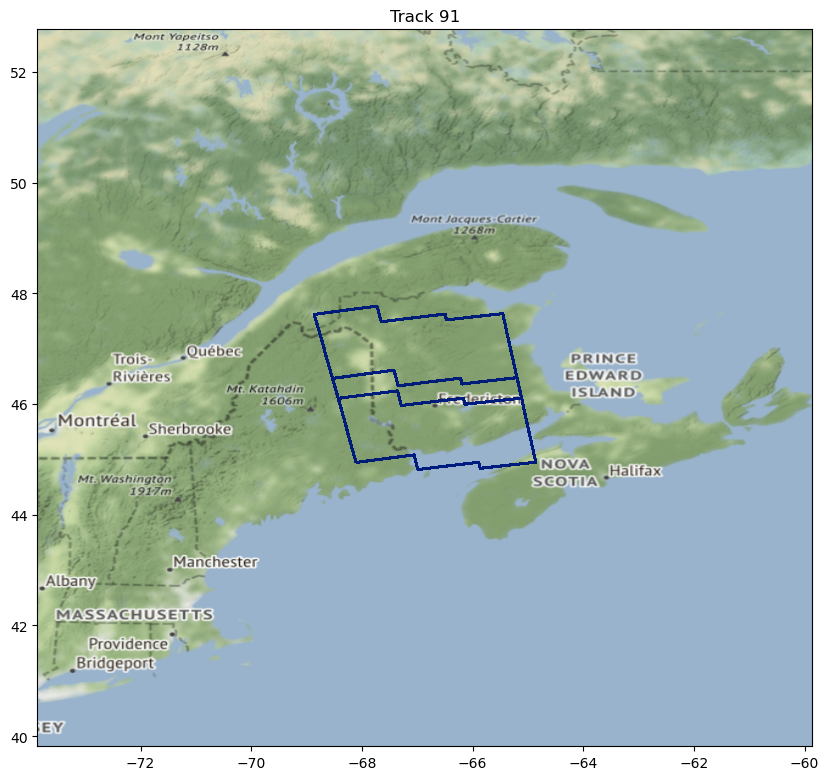

In [40]:
ll_buff = 5
fig, ax = plt.subplots(figsize=(10,10))
df.boundary.plot(ax=ax, alpha=0.25)
ax.set_xlim(W - ll_buff, E + ll_buff)
ax.set_ylim(S - ll_buff, N + ll_buff)
cx.add_basemap(ax, crs=df.crs.to_string(), attribution=False)
ax.set_title(f'Track {track}');

# Download

In [16]:
def download_one(asf_result):
    fn = f'{asf_result.properties["groupID"]}.nc'
    out_path = path_products / f'{fn}.nc'
    asf_result.download(path=str(path_products),
                        filename=fn)
    return out_path

In [35]:
# download_one(results[0])

PosixPath('products/S1-GUNW-A-R-091-tops-20230813_20230801-222023-00069W_00046N-PP-7961-v3_0_0.nc.nc')

In [18]:
with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
    paths = list(tqdm(executor.map(download_one, results[:]), total=len(results)))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2828/2828 [52:12<00:00,  1.11s/it]


Also see this: https://github.com/asfadmin/Discovery-asf_search/blob/master/examples/5-Download.ipynb

In [27]:
# Check number of files
len(list(path_products.glob('S1*.nc')))

2828